In [1]:
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import numpy as np


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.chdir("/home/thibault/Documents/oilprediction_challenge/Code/functions")
import skmice
import functions as fn

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", 200)

PATH = "/home/thibault/Documents/oilprediction_challenge/"
PATH_DATA = PATH + "Data/"
PATH_RESULT = PATH + "Result/"

# 1 - LOAD DATA

In [2]:
Y = pd.read_csv(PATH_DATA + "Y_train.csv", sep=";")
X = pd.read_csv(PATH_DATA + "Train.csv", sep=";")
final_test = pd.read_csv(PATH_DATA + "Test.csv", sep=";")

X_full = pd.concat([X, final_test])

# 2 - Data transformation

###### Missing value

In [3]:
n_0_in_lines = X.apply(lambda x: pd.isnull(x).sum(), axis=1)

# Keep only line with less than n missing value
X = X.loc[n_0_in_lines <= 20, :]
Y = Y.loc[n_0_in_lines <= 20, :]

X_full = pd.concat([X, final_test])

###### Outliers

No need for outliers handling using random Forest but we looked at it anyways.

# Create Variable

We Create binary varialbe => note realli working

In [4]:
column_to_transform = list(X_full.columns[3:])

###### Variation in country vs variation in all countries

In [5]:
column_to_transform_without_sum = [x for x in column_to_transform if (("Sum" not in x) and ("WTI" not in x))]

for var in column_to_transform_without_sum:
    X_full.loc[:, var + "_diff_with_global"] =\
        X_full.loc[:, var] / X_full.loc[:, var.split("diff")[0] + "diffSum" + var.split("diff")[1]]
    

###### If positiv

In [6]:
for var in column_to_transform:
    X_full.loc[:, "binary_if_positive_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_positive(x))

###### Create is 0

In [7]:
# Get columns with lot of 0
columns_with_0 =\
    [ x for x in column_to_transform if ("_diffClosing stocks(kmt)" in x or "_diffExports(kmt)" in x
                                        or "_diffImports(kmt)" in x or "_diffRefinery intake(kmt" in x) ]

for var in columns_with_0:
    X_full.loc[:, "binary_if_0_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_0(x))
        
binary_0_columns =\
    pd.Series(X_full.columns ).loc[pd.Series(X_full.columns ).map(lambda x: "binary_if_0_" in x)]

###### Percent of 0 by columns, country and month

In [8]:
for var in columns_with_0:
    if var == columns_with_0[0]:
        grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
    else:
        temp_grouped_0_values =\
            X_full.loc[:, [var] + ["country", "month"]].groupby(["country", "month"])[var].\
                apply(lambda x: (x ==0).mean()).reset_index()
        grouped_0_values = grouped_0_values.merge(temp_grouped_0_values, how="left",
                                                 on=["country", "month"])
        
grouped_0_values.columns = list(grouped_0_values.columns[:2]) +\
                               ["percent_0_" + x for x in list(grouped_0_values.columns[2:])]
    
X_full = X_full.merge(grouped_0_values, how="left", on=["country", "month"])

###### Binary if 0

In [9]:
for var in column_to_transform:
    X_full.loc[:, "binary_if_null_" + var] =\
        X_full.loc[:, var].map(lambda x: fn.binary_if_null(x))

###### Aggregate by month and country

In [10]:
grouped_values =\
    X_full.loc[:, column_to_transform + ["country", "month"]].replace(0, np.nan).groupby(["country", "month"]).\
        agg([np.nansum, np.nanmean, np.nanstd, np.min, 
             np.max, np.nanmedian, fn.percentile(75),
             fn.percentile(25), fn.percentile(10), fn.percentile(90),
             fn.percentile(5), fn.percentile(95)]).reset_index()
    
grouped_values.columns = [' '.join(col).strip() for col in grouped_values.columns.values]

X_full = X_full.merge(grouped_values, how="left", on=["country", "month"])

/home/thibault/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


###### Aggregate by country

In [11]:
grouped_values =\
    X_full.loc[:, column_to_transform + ["country"]].replace(0, np.nan).groupby(["country"]).\
        agg([np.nansum, np.nanmean, np.nanstd, np.min, 
             np.max, np.nanmedian, fn.percentile(75),
             fn.percentile(25), fn.percentile(10), fn.percentile(90),
             fn.percentile(5), fn.percentile(95)]).reset_index()
    
grouped_values.columns = [fn.new_name_if_not_id(' '.join(col).strip(), "_country_", "country") 
                          for col in grouped_values.columns.values]

X_full = X_full.merge(grouped_values, how="left", on="country")

/home/thibault/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/thibault/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


###### Diff between export and import

Variation of commercial balance for oil

In [12]:
column_import =\
    [ x for x in column_to_transform if ("_diffImports(kmt)" in x) ]
    
column_export =\
    [ x for x in column_to_transform if ("_diffExports(kmt)" in x) ]
    
columns_import_export = [(a,b) for a,b in zip(column_import, column_export)]

for (a, b) in columns_import_export:
    X_full.loc[:, a + b] = X_full.loc[:, a] - X_full.loc[:, b]

###### Diff_import_export + closing stock

Variation of commercial balance + variation of stock

In [13]:
columns_closing_stocks =\
    [ x for x in column_to_transform if ("_diffClosing stocks(kmt)" in x) ]
    
columns_import_export_closing_stock = [(a, b, c) for (a, b, c) in zip(column_import, column_export, columns_closing_stocks)]


In [14]:
for (a, b, c) in columns_import_export_closing_stock:
    X_full.loc[:, a + b + c] = X_full.loc[:, c] + (X_full.loc[:, a] - X_full.loc[:, b])

###### Countries with no variation in import and export

In [15]:
countries_with_no_variation_in_import =\
    X_full.loc[:, ["1_diffImports(kmt)", "country"]].groupby("country")["1_diffImports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [16]:
countries_with_no_variation_in_export =\
    X_full.loc[:, ["1_diffExports(kmt)", "country"]].groupby("country")["1_diffExports(kmt)"].\
        apply(lambda x: (x == 0).mean()).reset_index()

In [17]:
countries_with_no_variation_in_import_export =\
    countries_with_no_variation_in_import.merge(countries_with_no_variation_in_export, how="left",
                                               on="country")
    
countries_with_no_variation_in_import_export.loc[:, "no_import_variation"] =\
    countries_with_no_variation_in_import.loc[:, "1_diffImports(kmt)"] == 1

countries_with_no_variation_in_import_export.loc[:, "no_export_variation"] =\
    countries_with_no_variation_in_export.loc[:, "1_diffExports(kmt)"] == 1
    
countries_with_no_variation_in_import_export.loc[:, "no_export_nor_import_variation"] =\
    countries_with_no_variation_in_import_export.no_import_variation &\
    countries_with_no_variation_in_import_export.no_export_variation
    
X_full =\
    X_full.merge(countries_with_no_variation_in_import_export, how="left",
                on="country")

###### Compute relative value by countries

In [18]:
# Columns prefix to delete month in column name
col_names_without_month = set([x.split("_")[1] for x in column_to_transform])

# By countries
relative_value = pd.DataFrame()
for var in list(col_names_without_month):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
        median_value = fn.data_frame_as_Series(X_full.loc[X_full.country == localisation, all_months_columns]).\
            dropna().sum()
        relative_value_by_countries_columns =\
            X_full.loc[X_full.country == localisation, all_months_columns] / median_value
        # replace inf
        relative_value_by_countries_columns =\
            relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
        relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[X_full.country == localisation, "ID"]
        if relative_value_by_countries.empty:
            relative_value_by_countries = relative_value_by_countries_columns
        else:
            relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                     relative_value_by_countries_columns],
                                                   axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")


In [19]:
relative_value.columns = [fn.new_name_if_not_id(x, "relative_by_countries_") 
                          for x in list(relative_value.columns)]

In [20]:
X_full = X_full.merge(relative_value, how="left", on="ID")

###### Compute relative values by countries and month

In [21]:
# By countries
relative_value = pd.DataFrame()
for var in list(col_names_without_month):
    relative_value_by_countries = pd.DataFrame()
    for localisation in set(X_full.country):
        for month in set(X_full.month):
            all_months_columns = [str(j) + "_" + var for j in range(1, 13)]
            median_value = fn.data_frame_as_Series(X_full.loc[(X_full.country == localisation) &
                                                   (X_full.month == month), all_months_columns]).\
                dropna().sum()
            relative_value_by_countries_columns =\
                X_full.loc[(X_full.country == localisation) &
                           (X_full.month == month), all_months_columns] / median_value
            # replace inf
            relative_value_by_countries_columns =\
                relative_value_by_countries_columns.replace([np.inf, -np.inf], np.nan)
            relative_value_by_countries_columns.loc[:, "ID"] = X_full.loc[(X_full.country == localisation) &
                                                                          (X_full.month == month), "ID"]
            if relative_value_by_countries.empty:
                relative_value_by_countries = relative_value_by_countries_columns
            else:
                relative_value_by_countries = pd.concat([relative_value_by_countries, 
                                                         relative_value_by_countries_columns],
                                                       axis=0)
    if relative_value.empty:
        relative_value = relative_value_by_countries
    else:
        relative_value = relative_value.merge(relative_value_by_countries, on="ID", how="left")

In [22]:
relative_value.columns = [fn.new_name_if_not_id(x, "relative_by_countries_month_") 
                          for x in list(relative_value.columns)]

In [23]:
X_full = X_full.merge(relative_value, how="left", on="ID")

# Split again between test and validation

###### Transform month and country to categorical variable

In [24]:
# We put only country as categorical because month seems to have higher impact as numeric
X_full = pd.get_dummies(X_full, columns=["country"], drop_first=True)

###### Split dataset

In [25]:
X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

# 3 - Model

# Fast model for feature enginerring

In [26]:
n_iter_search = 12

###### Random Forest

In [27]:
param_dist = {
              "rf__max_features": sp_randint(1, 150),
              "rf__min_samples_split": sp_randint(2, 30),
              "rf__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "rf__n_estimators": sp_randint(20, 500)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("rf", RandomForestClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

rf_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.833522604821
{'rf__max_features': 71, 'rf__min_samples_leaf': 17, 'rf__min_samples_split': 7, 'rf__n_estimators': 345}


###### Gradient boosting

In [28]:
param_dist = {
              "gb__max_features": sp_randint(1, 100),
              "gb__min_samples_split": sp_randint(2, 30),
              "gb__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "gb__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("gb", GradientBoostingClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

gb_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.827095844925
{'gb__max_features': 30, 'gb__min_samples_leaf': 7, 'gb__min_samples_split': 13, 'gb__n_estimators': 128}


###### Extra tree

In [30]:
param_dist = {
              "et__max_features": sp_randint(1, 100),
              "et__min_samples_split": sp_randint(2, 30),
              "et__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              # "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              "et__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 # ("pca", PCA(n_components=150, whiten=True)),
                 ("et", ExtraTreesClassifier())
                 # ("rf", LogisticRegression(penalty="l1"))
                ])


random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

et_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.83270537627
{'et__max_features': 65, 'et__min_samples_leaf': 10, 'et__min_samples_split': 12, 'et__n_estimators': 309}


###### New model with feature from previous model

In [31]:
rf_proba_predictions = rf_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]
gb_proba_predictions = gb_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]
et_proba_predictions = et_estimator.predict_proba(X_full.drop(["ID"], axis=1))[:, 1]


X_full.loc[:, "prediction_rf"] = rf_proba_predictions
X_full.loc[:, "prediction_gb"] = gb_proba_predictions
X_full.loc[:, "prediction_et"] = gb_proba_predictions

X = X_full.loc[X_full.ID.map(lambda x: x in list(X.ID)), :]
final_test = X_full.loc[X_full.ID.map(lambda x: x in list(final_test.ID)), :]

X_train, X_test, y_train, y_test =\
    train_test_split(X, Y, test_size=0.33, random_state=42)

In [33]:
param_dist = {
              # "lr__max_features": sp_randint(1, 100),
              # "lr__min_samples_split": sp_randint(2, 30),
              # "lr__min_samples_leaf": sp_randint(1, 20),
              # "rf__bootstrap": [False],
              "pca__n_components": sp_randint(10, 300),
              # "pca__whiten": [True, False],
              # "select_from_model__threshold":sp_randint(0, 0.01),
              # "lr__n_estimators": sp_randint(20, 400)
             }

pipe = Pipeline([# ("replace_0", Replace0()),
                 ("imputer", Imputer()),
                 ("sd_scaler", StandardScaler()),
                 ("pca", PCA(n_components=150, whiten=True)),
                 ("lr", LogisticRegression("l1"))
                 # ("rf", LogisticRegression(penalty="l1"))
                ])

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4, scoring="roc_auc")

random_search.fit(X_train.drop("ID", axis=1), y_train.Target)

print(random_search.best_score_)

lr_estimator = random_search.best_estimator_

print(random_search.best_params_)

0.879991013008
{'pca__n_components': 292}


# 4 - EVALUATION

### A) Random Forest

###### Train set

In [34]:
y_train_predit = rf_estimator.predict_proba(X_train.drop(["ID", "prediction_rf", 
                                                          "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_train).merge(pd.DataFrame(y_train_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_train.Target, y_train_predit)

0.92285970522176897

###### Test set

In [35]:
y_test_predit = rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82513436304653076

### B) Gradient boosting

###### Test set

In [36]:
y_test_predit = gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82481963879339548

### C) Extra tree

###### Test set

In [38]:
y_test_predit = et_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                        "prediction_gb", "prediction_et"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82413571878177505

### D) Logistic regression

In [39]:
y_test_predit = lr_estimator.predict_proba(X_test.drop(["ID"], axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.80111767459126204

### E) Combining estimator

In [43]:
y_test_predit = 0.31 * rf_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.31 * gb_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.31 * et_estimator.predict_proba(X_test.drop(["ID", "prediction_rf", 
                                                               "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
                0.07 * lr_estimator.predict_proba(X_test.drop("ID", axis=1))[:, 1]

result_comparison = pd.DataFrame(y_test).merge(pd.DataFrame(y_test_predit), left_index=True, right_index=True)
result_comparison.sample(10)

roc_auc_score(y_test.Target, y_test_predit)

0.82704651463064283

# Variable importance

We can see lot of features with importance < 0.005

(array([  3.52900000e+03,   1.14000000e+02,   3.10000000e+01,
          1.00000000e+01,   2.20000000e+01,   1.30000000e+01,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.00078177,  0.00156353,  0.0023453 ,  0.00312706,
         0.00390883,  0.00469059,  0.00547236,  0.00625412,  0.00703589,
         0.00781765]),
 <a list of 10 Patch objects>)

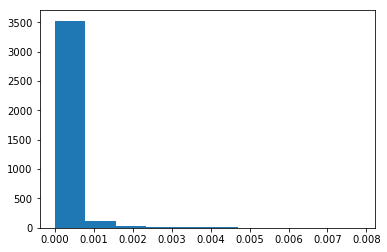

In [44]:
plt.hist(rf_estimator.named_steps["rf"].feature_importances_)

In [45]:
variable_importance =\
    pd.concat([pd.DataFrame(X_train.columns),
               pd.DataFrame(rf_estimator.named_steps["rf"].feature_importances_)], axis=1)
variable_importance.columns =["variable", "importance"]
    
variable_importance = variable_importance.sort_values(by="importance", ascending=False)
variable_importance.head(15)

,variable,importance
619,1_diffSumRefinery intake(kmt) nanmedian,0.007818
584,1_diffSumExports(kmt) percentile_75,0.006444
590,1_diffSumImports(kmt) nansum,0.005388
583,1_diffSumExports(kmt) nanmedian,0.005179
358,percent_0_6_diffClosing stocks(kmt),0.005178
1932,12_diffSumProduction(kmt) percentile_5,0.004784
598,1_diffSumImports(kmt) percentile_10,0.004623
589,1_diffSumExports(kmt) percentile_95,0.004543
577,1_diffSumClosing stocks(kmt) percentile_95,0.004538
366,percent_0_8_diffClosing stocks(kmt),0.004499


# 5 - Prediction

In [46]:
id_final_test = final_test.ID

In [47]:
X_final_test = final_test.drop("ID", axis=1)

In [51]:
predictions = 0.33 * rf_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.33 * gb_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.34 * et_estimator.predict_proba(X_final_test.drop(["prediction_rf", 
                                                                   "prediction_gb", "prediction_et"], axis=1))[:, 1] +\
              0.00 * lr_estimator.predict_proba(X_final_test)[:, 1]
    

/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [52]:
result = pd.DataFrame(predictions).merge(pd.DataFrame(id_final_test).reset_index(drop=True), 
                                         left_index=True, right_index=True)
result.columns = ["Target", "ID"]
result = result.loc[:, ["ID", "Target"]]
result.head()

,ID,Target
0,ID10160,0.292571
1,ID10161,0.021153
2,ID10162,0.424225
3,ID10163,0.808301
4,ID10164,0.245966


In [53]:

result.to_csv(PATH_RESULT + "result.csv", index=False, sep=";", quoting=csv.QUOTE_NONNUMERIC)